In [2]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np


Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [3]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

    

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

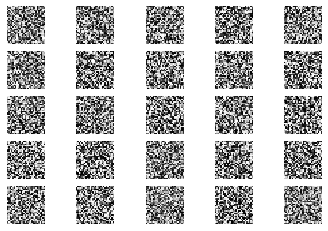

1 [D loss: 0.479161, acc.: 81.25%] [G loss: 0.972008]
2 [D loss: 0.324292, acc.: 87.50%] [G loss: 0.997393]
3 [D loss: 0.272617, acc.: 93.75%] [G loss: 1.139122]
4 [D loss: 0.250858, acc.: 93.75%] [G loss: 1.158106]
5 [D loss: 0.235009, acc.: 96.88%] [G loss: 1.368717]
6 [D loss: 0.178380, acc.: 100.00%] [G loss: 1.395625]
7 [D loss: 0.171168, acc.: 100.00%] [G loss: 1.573260]
8 [D loss: 0.145266, acc.: 100.00%] [G loss: 1.651000]
9 [D loss: 0.138736, acc.: 100.00%] [G loss: 1.755559]
10 [D loss: 0.128809, acc.: 100.00%] [G loss: 1.813796]
11 [D loss: 0.101934, acc.: 100.00%] [G loss: 1.945169]
12 [D loss: 0.087848, acc.: 100.00%] [G loss: 1.994293]
13 [D loss: 0.105379, acc.: 100.00%] [G loss: 2.051195]
14 [D loss: 0.099287, acc.: 100.00%] [G loss: 2.130564]
15 [D loss: 0.095632, acc.: 100.00%] [G loss: 2.222227]
16 [D loss: 0.094357, acc.: 100.00%] [G loss: 2.211575]
17 [D loss: 0.073138, acc.: 100.00%] [G loss: 2.335803]
18 [D loss: 0.071251, acc.: 100.00%] [G loss: 2.367938]
19 [D 

149 [D loss: 0.064194, acc.: 100.00%] [G loss: 3.896443]
150 [D loss: 0.118162, acc.: 96.88%] [G loss: 4.042469]
151 [D loss: 0.271169, acc.: 89.06%] [G loss: 3.215375]
152 [D loss: 0.226743, acc.: 92.19%] [G loss: 3.947452]
153 [D loss: 0.213264, acc.: 92.19%] [G loss: 3.782924]
154 [D loss: 0.351336, acc.: 82.81%] [G loss: 3.523991]
155 [D loss: 0.095114, acc.: 98.44%] [G loss: 4.181915]
156 [D loss: 0.586044, acc.: 75.00%] [G loss: 2.953187]
157 [D loss: 0.233119, acc.: 93.75%] [G loss: 3.265136]
158 [D loss: 0.196339, acc.: 92.19%] [G loss: 3.580101]
159 [D loss: 0.145112, acc.: 96.88%] [G loss: 3.733661]
160 [D loss: 0.322640, acc.: 84.38%] [G loss: 2.460504]
161 [D loss: 0.169138, acc.: 93.75%] [G loss: 3.288612]
162 [D loss: 0.085498, acc.: 98.44%] [G loss: 3.552178]
163 [D loss: 0.243836, acc.: 87.50%] [G loss: 3.306626]
164 [D loss: 0.201870, acc.: 95.31%] [G loss: 3.533359]
165 [D loss: 0.188929, acc.: 95.31%] [G loss: 3.059381]
166 [D loss: 0.112421, acc.: 98.44%] [G loss: 3

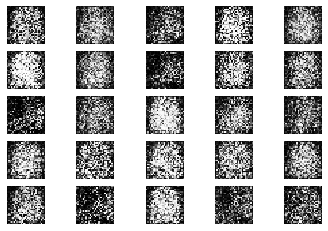

201 [D loss: 0.478965, acc.: 78.12%] [G loss: 2.657677]
202 [D loss: 0.408892, acc.: 84.38%] [G loss: 2.877152]
203 [D loss: 0.390708, acc.: 78.12%] [G loss: 3.093171]
204 [D loss: 0.427197, acc.: 81.25%] [G loss: 2.161075]
205 [D loss: 0.343164, acc.: 84.38%] [G loss: 3.195676]
206 [D loss: 0.644227, acc.: 67.19%] [G loss: 2.117841]
207 [D loss: 0.311086, acc.: 89.06%] [G loss: 3.174034]
208 [D loss: 0.413802, acc.: 81.25%] [G loss: 3.329868]
209 [D loss: 0.447116, acc.: 79.69%] [G loss: 2.142446]
210 [D loss: 0.479103, acc.: 78.12%] [G loss: 3.389969]
211 [D loss: 0.625912, acc.: 73.44%] [G loss: 1.928375]
212 [D loss: 0.374454, acc.: 85.94%] [G loss: 3.227984]
213 [D loss: 0.672940, acc.: 64.06%] [G loss: 2.668890]
214 [D loss: 0.404273, acc.: 87.50%] [G loss: 2.466403]
215 [D loss: 0.423343, acc.: 82.81%] [G loss: 2.355354]
216 [D loss: 0.301009, acc.: 95.31%] [G loss: 2.521847]
217 [D loss: 0.588979, acc.: 73.44%] [G loss: 2.126554]
218 [D loss: 0.547968, acc.: 76.56%] [G loss: 2.

349 [D loss: 0.605814, acc.: 67.19%] [G loss: 1.087148]
350 [D loss: 0.593233, acc.: 73.44%] [G loss: 1.119825]
351 [D loss: 0.645085, acc.: 60.94%] [G loss: 1.032034]
352 [D loss: 0.535429, acc.: 71.88%] [G loss: 1.116987]
353 [D loss: 0.660197, acc.: 59.38%] [G loss: 1.050166]
354 [D loss: 0.550624, acc.: 76.56%] [G loss: 1.112572]
355 [D loss: 0.569939, acc.: 68.75%] [G loss: 0.999195]
356 [D loss: 0.552924, acc.: 70.31%] [G loss: 1.097566]
357 [D loss: 0.655633, acc.: 64.06%] [G loss: 1.098572]
358 [D loss: 0.624917, acc.: 64.06%] [G loss: 1.064460]
359 [D loss: 0.615841, acc.: 62.50%] [G loss: 0.993755]
360 [D loss: 0.593475, acc.: 70.31%] [G loss: 1.029662]
361 [D loss: 0.698749, acc.: 64.06%] [G loss: 1.030936]
362 [D loss: 0.614023, acc.: 67.19%] [G loss: 0.997245]
363 [D loss: 0.608569, acc.: 71.88%] [G loss: 0.960334]
364 [D loss: 0.586387, acc.: 67.19%] [G loss: 1.009643]
365 [D loss: 0.676977, acc.: 54.69%] [G loss: 1.083220]
366 [D loss: 0.514361, acc.: 81.25%] [G loss: 1.

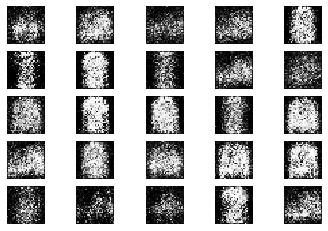

401 [D loss: 0.617423, acc.: 68.75%] [G loss: 0.990509]
402 [D loss: 0.608431, acc.: 62.50%] [G loss: 0.960301]
403 [D loss: 0.539444, acc.: 76.56%] [G loss: 0.978209]
404 [D loss: 0.604706, acc.: 68.75%] [G loss: 1.050974]
405 [D loss: 0.575567, acc.: 70.31%] [G loss: 1.046337]
406 [D loss: 0.633499, acc.: 60.94%] [G loss: 0.964368]
407 [D loss: 0.644332, acc.: 65.62%] [G loss: 0.959888]
408 [D loss: 0.626978, acc.: 64.06%] [G loss: 0.912669]
409 [D loss: 0.556085, acc.: 75.00%] [G loss: 1.012209]
410 [D loss: 0.611311, acc.: 62.50%] [G loss: 0.960949]
411 [D loss: 0.585282, acc.: 70.31%] [G loss: 1.030120]
412 [D loss: 0.555266, acc.: 71.88%] [G loss: 1.094445]
413 [D loss: 0.616090, acc.: 70.31%] [G loss: 0.977340]
414 [D loss: 0.552832, acc.: 75.00%] [G loss: 0.958201]
415 [D loss: 0.655440, acc.: 57.81%] [G loss: 0.916116]
416 [D loss: 0.624593, acc.: 59.38%] [G loss: 0.987323]
417 [D loss: 0.634939, acc.: 65.62%] [G loss: 1.094153]
418 [D loss: 0.622323, acc.: 62.50%] [G loss: 1.

548 [D loss: 0.701072, acc.: 53.12%] [G loss: 0.837163]
549 [D loss: 0.605793, acc.: 67.19%] [G loss: 0.937691]
550 [D loss: 0.596502, acc.: 64.06%] [G loss: 0.929035]
551 [D loss: 0.639986, acc.: 67.19%] [G loss: 0.883048]
552 [D loss: 0.679953, acc.: 56.25%] [G loss: 0.896507]
553 [D loss: 0.644541, acc.: 60.94%] [G loss: 0.884265]
554 [D loss: 0.601234, acc.: 70.31%] [G loss: 0.819639]
555 [D loss: 0.639859, acc.: 62.50%] [G loss: 1.045616]
556 [D loss: 0.601657, acc.: 65.62%] [G loss: 1.082093]
557 [D loss: 0.648204, acc.: 59.38%] [G loss: 0.928505]
558 [D loss: 0.640679, acc.: 65.62%] [G loss: 0.963945]
559 [D loss: 0.634432, acc.: 64.06%] [G loss: 0.893219]
560 [D loss: 0.677706, acc.: 64.06%] [G loss: 0.908387]
561 [D loss: 0.642499, acc.: 67.19%] [G loss: 0.870146]
562 [D loss: 0.604814, acc.: 71.88%] [G loss: 1.036456]
563 [D loss: 0.702594, acc.: 53.12%] [G loss: 0.954863]
564 [D loss: 0.591349, acc.: 68.75%] [G loss: 1.011977]
565 [D loss: 0.622451, acc.: 71.88%] [G loss: 0.

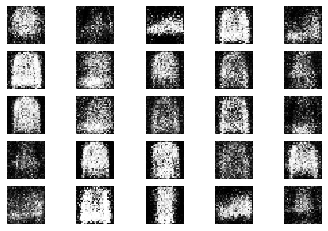

601 [D loss: 0.675439, acc.: 48.44%] [G loss: 0.882495]
602 [D loss: 0.649742, acc.: 59.38%] [G loss: 0.903678]
603 [D loss: 0.636031, acc.: 64.06%] [G loss: 0.824238]
604 [D loss: 0.609675, acc.: 62.50%] [G loss: 0.900502]
605 [D loss: 0.654103, acc.: 59.38%] [G loss: 0.858762]
606 [D loss: 0.618329, acc.: 65.62%] [G loss: 0.917570]
607 [D loss: 0.647943, acc.: 67.19%] [G loss: 0.936260]
608 [D loss: 0.579056, acc.: 75.00%] [G loss: 0.908423]
609 [D loss: 0.632157, acc.: 62.50%] [G loss: 0.887091]
610 [D loss: 0.660199, acc.: 64.06%] [G loss: 0.897602]
611 [D loss: 0.659086, acc.: 60.94%] [G loss: 0.927259]
612 [D loss: 0.623237, acc.: 68.75%] [G loss: 0.806814]
613 [D loss: 0.629906, acc.: 62.50%] [G loss: 0.850232]
614 [D loss: 0.608103, acc.: 75.00%] [G loss: 0.824386]
615 [D loss: 0.604598, acc.: 64.06%] [G loss: 0.970951]
616 [D loss: 0.669240, acc.: 56.25%] [G loss: 0.896165]
617 [D loss: 0.618926, acc.: 60.94%] [G loss: 0.886286]
618 [D loss: 0.604706, acc.: 68.75%] [G loss: 0.

748 [D loss: 0.638485, acc.: 60.94%] [G loss: 0.819924]
749 [D loss: 0.640409, acc.: 62.50%] [G loss: 0.839601]
750 [D loss: 0.630555, acc.: 65.62%] [G loss: 0.837235]
751 [D loss: 0.661872, acc.: 62.50%] [G loss: 0.785522]
752 [D loss: 0.626737, acc.: 64.06%] [G loss: 0.788591]
753 [D loss: 0.644923, acc.: 62.50%] [G loss: 0.985280]
754 [D loss: 0.724358, acc.: 53.12%] [G loss: 0.867182]
755 [D loss: 0.663118, acc.: 64.06%] [G loss: 0.861100]
756 [D loss: 0.626367, acc.: 62.50%] [G loss: 0.906439]
757 [D loss: 0.563151, acc.: 75.00%] [G loss: 0.899163]
758 [D loss: 0.636665, acc.: 59.38%] [G loss: 0.972752]
759 [D loss: 0.648400, acc.: 56.25%] [G loss: 0.928543]
760 [D loss: 0.686507, acc.: 57.81%] [G loss: 0.833407]
761 [D loss: 0.613422, acc.: 62.50%] [G loss: 0.921730]
762 [D loss: 0.609441, acc.: 65.62%] [G loss: 0.881754]
763 [D loss: 0.673875, acc.: 60.94%] [G loss: 0.846504]
764 [D loss: 0.757086, acc.: 53.12%] [G loss: 0.876021]
765 [D loss: 0.634220, acc.: 65.62%] [G loss: 0.

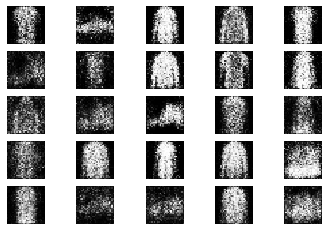

801 [D loss: 0.680714, acc.: 54.69%] [G loss: 0.843508]
802 [D loss: 0.639984, acc.: 64.06%] [G loss: 0.843529]
803 [D loss: 0.657562, acc.: 70.31%] [G loss: 0.866755]
804 [D loss: 0.671198, acc.: 57.81%] [G loss: 0.851392]
805 [D loss: 0.664084, acc.: 62.50%] [G loss: 0.899230]
806 [D loss: 0.610745, acc.: 64.06%] [G loss: 1.027135]
807 [D loss: 0.594434, acc.: 67.19%] [G loss: 1.024443]
808 [D loss: 0.612570, acc.: 65.62%] [G loss: 0.953286]
809 [D loss: 0.630935, acc.: 65.62%] [G loss: 0.889310]
810 [D loss: 0.578255, acc.: 73.44%] [G loss: 0.850569]
811 [D loss: 0.675277, acc.: 64.06%] [G loss: 0.867983]
812 [D loss: 0.606979, acc.: 68.75%] [G loss: 0.953661]
813 [D loss: 0.636289, acc.: 62.50%] [G loss: 0.927182]
814 [D loss: 0.644198, acc.: 57.81%] [G loss: 0.953169]
815 [D loss: 0.595361, acc.: 76.56%] [G loss: 0.862493]
816 [D loss: 0.689457, acc.: 59.38%] [G loss: 0.859234]
817 [D loss: 0.582645, acc.: 68.75%] [G loss: 0.869477]
818 [D loss: 0.615082, acc.: 68.75%] [G loss: 0.

949 [D loss: 0.626920, acc.: 60.94%] [G loss: 0.849820]
950 [D loss: 0.589894, acc.: 68.75%] [G loss: 0.897477]
951 [D loss: 0.633293, acc.: 57.81%] [G loss: 0.931555]
952 [D loss: 0.648810, acc.: 64.06%] [G loss: 0.842648]
953 [D loss: 0.649455, acc.: 59.38%] [G loss: 0.880449]
954 [D loss: 0.665525, acc.: 56.25%] [G loss: 0.862769]
955 [D loss: 0.592406, acc.: 73.44%] [G loss: 0.878173]
956 [D loss: 0.603552, acc.: 70.31%] [G loss: 0.917317]
957 [D loss: 0.607685, acc.: 68.75%] [G loss: 0.907526]
958 [D loss: 0.689441, acc.: 56.25%] [G loss: 0.889185]
959 [D loss: 0.614152, acc.: 65.62%] [G loss: 0.913368]
960 [D loss: 0.658980, acc.: 57.81%] [G loss: 0.804252]
961 [D loss: 0.699521, acc.: 56.25%] [G loss: 0.930117]
962 [D loss: 0.613374, acc.: 68.75%] [G loss: 0.843090]
963 [D loss: 0.682044, acc.: 62.50%] [G loss: 0.845918]
964 [D loss: 0.673902, acc.: 62.50%] [G loss: 0.809925]
965 [D loss: 0.711877, acc.: 54.69%] [G loss: 0.859730]
966 [D loss: 0.631180, acc.: 54.69%] [G loss: 0.

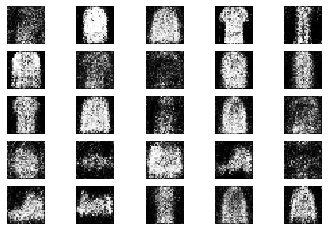

1001 [D loss: 0.630273, acc.: 65.62%] [G loss: 0.914467]
1002 [D loss: 0.602774, acc.: 71.88%] [G loss: 0.876989]
1003 [D loss: 0.673829, acc.: 56.25%] [G loss: 0.847810]
1004 [D loss: 0.645694, acc.: 57.81%] [G loss: 0.786044]
1005 [D loss: 0.656583, acc.: 67.19%] [G loss: 0.798460]
1006 [D loss: 0.610098, acc.: 67.19%] [G loss: 0.829707]
1007 [D loss: 0.603119, acc.: 64.06%] [G loss: 0.880571]
1008 [D loss: 0.646102, acc.: 65.62%] [G loss: 0.815733]
1009 [D loss: 0.603038, acc.: 68.75%] [G loss: 0.895908]
1010 [D loss: 0.614725, acc.: 65.62%] [G loss: 0.821817]
1011 [D loss: 0.685147, acc.: 62.50%] [G loss: 0.983266]
1012 [D loss: 0.646352, acc.: 62.50%] [G loss: 0.879891]
1013 [D loss: 0.619313, acc.: 70.31%] [G loss: 0.797786]
1014 [D loss: 0.607571, acc.: 64.06%] [G loss: 0.763623]
1015 [D loss: 0.626962, acc.: 59.38%] [G loss: 0.755586]
1016 [D loss: 0.744684, acc.: 51.56%] [G loss: 0.753173]
1017 [D loss: 0.631785, acc.: 64.06%] [G loss: 0.868703]
1018 [D loss: 0.633896, acc.: 5

1146 [D loss: 0.631461, acc.: 65.62%] [G loss: 0.921718]
1147 [D loss: 0.624340, acc.: 65.62%] [G loss: 0.869047]
1148 [D loss: 0.682199, acc.: 57.81%] [G loss: 0.797500]
1149 [D loss: 0.627045, acc.: 65.62%] [G loss: 0.847743]
1150 [D loss: 0.663460, acc.: 60.94%] [G loss: 0.816747]
1151 [D loss: 0.667974, acc.: 59.38%] [G loss: 0.942068]
1152 [D loss: 0.633659, acc.: 70.31%] [G loss: 0.851139]
1153 [D loss: 0.614811, acc.: 62.50%] [G loss: 0.805203]
1154 [D loss: 0.678990, acc.: 46.88%] [G loss: 0.783239]
1155 [D loss: 0.620084, acc.: 65.62%] [G loss: 0.835380]
1156 [D loss: 0.553776, acc.: 75.00%] [G loss: 0.766904]
1157 [D loss: 0.608092, acc.: 68.75%] [G loss: 0.916113]
1158 [D loss: 0.626350, acc.: 64.06%] [G loss: 0.880521]
1159 [D loss: 0.796367, acc.: 46.88%] [G loss: 0.821944]
1160 [D loss: 0.613023, acc.: 68.75%] [G loss: 0.888628]
1161 [D loss: 0.648626, acc.: 56.25%] [G loss: 0.901710]
1162 [D loss: 0.633658, acc.: 70.31%] [G loss: 0.877620]
1163 [D loss: 0.679789, acc.: 6

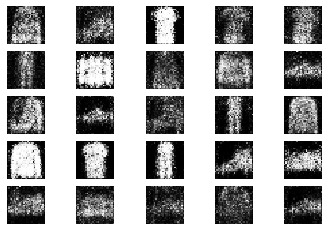

1201 [D loss: 0.653636, acc.: 56.25%] [G loss: 0.886613]
1202 [D loss: 0.606981, acc.: 73.44%] [G loss: 0.829182]
1203 [D loss: 0.636820, acc.: 64.06%] [G loss: 0.898061]
1204 [D loss: 0.639433, acc.: 57.81%] [G loss: 0.921724]
1205 [D loss: 0.588837, acc.: 71.88%] [G loss: 0.852580]
1206 [D loss: 0.624932, acc.: 60.94%] [G loss: 0.806619]
1207 [D loss: 0.574630, acc.: 71.88%] [G loss: 0.913448]
1208 [D loss: 0.688032, acc.: 59.38%] [G loss: 0.932290]
1209 [D loss: 0.671047, acc.: 60.94%] [G loss: 0.899132]
1210 [D loss: 0.630014, acc.: 59.38%] [G loss: 0.928421]
1211 [D loss: 0.624817, acc.: 68.75%] [G loss: 0.862082]
1212 [D loss: 0.646967, acc.: 59.38%] [G loss: 0.916721]
1213 [D loss: 0.636354, acc.: 56.25%] [G loss: 0.822624]
1214 [D loss: 0.653361, acc.: 60.94%] [G loss: 0.808096]
1215 [D loss: 0.631422, acc.: 64.06%] [G loss: 0.811017]
1216 [D loss: 0.696093, acc.: 53.12%] [G loss: 0.882129]
1217 [D loss: 0.623947, acc.: 67.19%] [G loss: 0.872221]
1218 [D loss: 0.618566, acc.: 7

1345 [D loss: 0.692934, acc.: 53.12%] [G loss: 0.855613]
1346 [D loss: 0.632928, acc.: 62.50%] [G loss: 0.852637]
1347 [D loss: 0.627614, acc.: 68.75%] [G loss: 0.901786]
1348 [D loss: 0.749423, acc.: 48.44%] [G loss: 0.830287]
1349 [D loss: 0.669396, acc.: 59.38%] [G loss: 0.838467]
1350 [D loss: 0.663000, acc.: 62.50%] [G loss: 0.886259]
1351 [D loss: 0.618081, acc.: 70.31%] [G loss: 0.983388]
1352 [D loss: 0.631808, acc.: 62.50%] [G loss: 0.934412]
1353 [D loss: 0.607984, acc.: 67.19%] [G loss: 0.926583]
1354 [D loss: 0.667616, acc.: 57.81%] [G loss: 0.805400]
1355 [D loss: 0.588666, acc.: 73.44%] [G loss: 0.890499]
1356 [D loss: 0.658579, acc.: 57.81%] [G loss: 0.820574]
1357 [D loss: 0.657370, acc.: 60.94%] [G loss: 0.876256]
1358 [D loss: 0.727938, acc.: 53.12%] [G loss: 0.821933]
1359 [D loss: 0.644898, acc.: 64.06%] [G loss: 0.789822]
1360 [D loss: 0.638913, acc.: 64.06%] [G loss: 0.801603]
1361 [D loss: 0.638991, acc.: 59.38%] [G loss: 0.911561]
1362 [D loss: 0.628851, acc.: 6

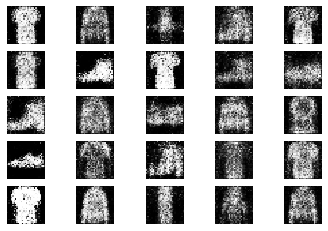

1401 [D loss: 0.689548, acc.: 57.81%] [G loss: 0.824712]
1402 [D loss: 0.696806, acc.: 56.25%] [G loss: 0.831144]
1403 [D loss: 0.676810, acc.: 59.38%] [G loss: 0.856217]
1404 [D loss: 0.649568, acc.: 67.19%] [G loss: 0.830656]
1405 [D loss: 0.598740, acc.: 64.06%] [G loss: 0.878838]
1406 [D loss: 0.648113, acc.: 62.50%] [G loss: 0.769708]
1407 [D loss: 0.670033, acc.: 54.69%] [G loss: 0.822724]
1408 [D loss: 0.669186, acc.: 51.56%] [G loss: 0.837508]
1409 [D loss: 0.637965, acc.: 60.94%] [G loss: 0.874646]
1410 [D loss: 0.622560, acc.: 64.06%] [G loss: 0.910609]
1411 [D loss: 0.620378, acc.: 64.06%] [G loss: 0.932091]
1412 [D loss: 0.575205, acc.: 68.75%] [G loss: 0.852675]
1413 [D loss: 0.601277, acc.: 70.31%] [G loss: 0.862549]
1414 [D loss: 0.612695, acc.: 62.50%] [G loss: 0.843208]
1415 [D loss: 0.609045, acc.: 65.62%] [G loss: 0.923633]
1416 [D loss: 0.606496, acc.: 59.38%] [G loss: 0.944881]
1417 [D loss: 0.651483, acc.: 54.69%] [G loss: 0.925335]
1418 [D loss: 0.622607, acc.: 6

1545 [D loss: 0.639736, acc.: 59.38%] [G loss: 0.799381]
1546 [D loss: 0.598596, acc.: 67.19%] [G loss: 0.936941]
1547 [D loss: 0.652773, acc.: 53.12%] [G loss: 0.960496]
1548 [D loss: 0.652406, acc.: 51.56%] [G loss: 0.834895]
1549 [D loss: 0.605392, acc.: 67.19%] [G loss: 0.902991]
1550 [D loss: 0.678393, acc.: 57.81%] [G loss: 0.955769]
1551 [D loss: 0.664753, acc.: 56.25%] [G loss: 0.860718]
1552 [D loss: 0.676581, acc.: 59.38%] [G loss: 0.902627]
1553 [D loss: 0.630785, acc.: 54.69%] [G loss: 0.968176]
1554 [D loss: 0.620354, acc.: 62.50%] [G loss: 0.943253]
1555 [D loss: 0.657167, acc.: 62.50%] [G loss: 0.929179]
1556 [D loss: 0.604286, acc.: 68.75%] [G loss: 0.926357]
1557 [D loss: 0.672362, acc.: 57.81%] [G loss: 0.881502]
1558 [D loss: 0.647064, acc.: 65.62%] [G loss: 0.834625]
1559 [D loss: 0.679564, acc.: 57.81%] [G loss: 0.903823]
1560 [D loss: 0.588908, acc.: 76.56%] [G loss: 0.877593]
1561 [D loss: 0.639078, acc.: 68.75%] [G loss: 0.864885]
1562 [D loss: 0.604745, acc.: 6

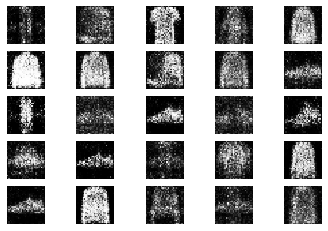

1601 [D loss: 0.672658, acc.: 64.06%] [G loss: 0.798644]
1602 [D loss: 0.602259, acc.: 64.06%] [G loss: 0.876365]
1603 [D loss: 0.584688, acc.: 65.62%] [G loss: 0.890673]
1604 [D loss: 0.650656, acc.: 68.75%] [G loss: 0.876473]
1605 [D loss: 0.612403, acc.: 70.31%] [G loss: 0.979770]
1606 [D loss: 0.661638, acc.: 59.38%] [G loss: 0.848657]
1607 [D loss: 0.592404, acc.: 65.62%] [G loss: 0.941999]
1608 [D loss: 0.621682, acc.: 68.75%] [G loss: 0.939197]
1609 [D loss: 0.633089, acc.: 62.50%] [G loss: 0.950018]
1610 [D loss: 0.663590, acc.: 60.94%] [G loss: 0.892309]
1611 [D loss: 0.656593, acc.: 57.81%] [G loss: 0.835123]
1612 [D loss: 0.615928, acc.: 60.94%] [G loss: 0.837277]
1613 [D loss: 0.662675, acc.: 64.06%] [G loss: 0.887899]
1614 [D loss: 0.653349, acc.: 60.94%] [G loss: 0.925279]
1615 [D loss: 0.657433, acc.: 65.62%] [G loss: 0.933028]
1616 [D loss: 0.605360, acc.: 68.75%] [G loss: 0.894434]
1617 [D loss: 0.613024, acc.: 73.44%] [G loss: 0.940066]
1618 [D loss: 0.608307, acc.: 7

1745 [D loss: 0.574474, acc.: 64.06%] [G loss: 0.842490]
1746 [D loss: 0.617855, acc.: 73.44%] [G loss: 0.827022]
1747 [D loss: 0.673370, acc.: 59.38%] [G loss: 0.913265]
1748 [D loss: 0.629862, acc.: 60.94%] [G loss: 0.932517]
1749 [D loss: 0.649370, acc.: 62.50%] [G loss: 0.863989]
1750 [D loss: 0.548204, acc.: 75.00%] [G loss: 0.941461]
1751 [D loss: 0.599101, acc.: 73.44%] [G loss: 0.822092]
1752 [D loss: 0.585120, acc.: 73.44%] [G loss: 0.964068]
1753 [D loss: 0.641487, acc.: 54.69%] [G loss: 0.961156]
1754 [D loss: 0.687761, acc.: 50.00%] [G loss: 0.891457]
1755 [D loss: 0.657095, acc.: 56.25%] [G loss: 1.014835]
1756 [D loss: 0.615770, acc.: 65.62%] [G loss: 0.967777]
1757 [D loss: 0.673247, acc.: 65.62%] [G loss: 0.945869]
1758 [D loss: 0.650339, acc.: 67.19%] [G loss: 1.038188]
1759 [D loss: 0.668719, acc.: 62.50%] [G loss: 0.851243]
1760 [D loss: 0.634706, acc.: 67.19%] [G loss: 0.972033]
1761 [D loss: 0.728299, acc.: 50.00%] [G loss: 0.924799]
1762 [D loss: 0.591896, acc.: 7

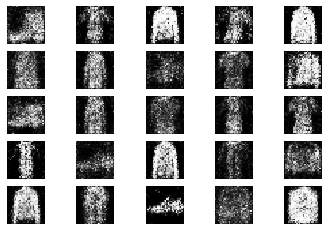

1801 [D loss: 0.681024, acc.: 57.81%] [G loss: 0.837106]
1802 [D loss: 0.630737, acc.: 68.75%] [G loss: 0.862140]
1803 [D loss: 0.561186, acc.: 71.88%] [G loss: 0.935765]
1804 [D loss: 0.686765, acc.: 54.69%] [G loss: 0.921359]
1805 [D loss: 0.615649, acc.: 64.06%] [G loss: 0.928060]
1806 [D loss: 0.622932, acc.: 65.62%] [G loss: 0.996067]
1807 [D loss: 0.698667, acc.: 51.56%] [G loss: 0.997737]
1808 [D loss: 0.668012, acc.: 51.56%] [G loss: 0.933571]
1809 [D loss: 0.644756, acc.: 62.50%] [G loss: 0.935889]
1810 [D loss: 0.643985, acc.: 65.62%] [G loss: 0.826586]
1811 [D loss: 0.627739, acc.: 70.31%] [G loss: 0.849923]
1812 [D loss: 0.613663, acc.: 67.19%] [G loss: 0.888902]
1813 [D loss: 0.616075, acc.: 65.62%] [G loss: 0.904028]
1814 [D loss: 0.575725, acc.: 73.44%] [G loss: 0.838916]
1815 [D loss: 0.660570, acc.: 65.62%] [G loss: 0.961137]
1816 [D loss: 0.651571, acc.: 67.19%] [G loss: 0.957396]
1817 [D loss: 0.583635, acc.: 70.31%] [G loss: 0.938666]
1818 [D loss: 0.643833, acc.: 5

1945 [D loss: 0.621323, acc.: 60.94%] [G loss: 0.877510]
1946 [D loss: 0.581515, acc.: 71.88%] [G loss: 0.858581]
1947 [D loss: 0.614980, acc.: 71.88%] [G loss: 0.888847]
1948 [D loss: 0.616343, acc.: 67.19%] [G loss: 0.963796]
1949 [D loss: 0.603676, acc.: 65.62%] [G loss: 0.815899]
1950 [D loss: 0.673853, acc.: 62.50%] [G loss: 0.878800]
1951 [D loss: 0.609085, acc.: 62.50%] [G loss: 0.887746]
1952 [D loss: 0.687817, acc.: 43.75%] [G loss: 0.867318]
1953 [D loss: 0.653900, acc.: 60.94%] [G loss: 0.839113]
1954 [D loss: 0.640483, acc.: 59.38%] [G loss: 0.917474]
1955 [D loss: 0.594560, acc.: 62.50%] [G loss: 0.968457]
1956 [D loss: 0.578684, acc.: 75.00%] [G loss: 0.971165]
1957 [D loss: 0.617363, acc.: 65.62%] [G loss: 0.950912]
1958 [D loss: 0.553608, acc.: 76.56%] [G loss: 0.936012]
1959 [D loss: 0.614932, acc.: 65.62%] [G loss: 0.900071]
1960 [D loss: 0.625355, acc.: 70.31%] [G loss: 0.843515]
1961 [D loss: 0.630850, acc.: 64.06%] [G loss: 0.909439]
1962 [D loss: 0.621221, acc.: 6

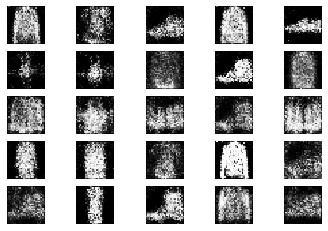

2001 [D loss: 0.591455, acc.: 68.75%] [G loss: 0.975270]
2002 [D loss: 0.578629, acc.: 68.75%] [G loss: 0.981600]
2003 [D loss: 0.538533, acc.: 75.00%] [G loss: 0.935611]
2004 [D loss: 0.625670, acc.: 59.38%] [G loss: 0.924829]
2005 [D loss: 0.594260, acc.: 62.50%] [G loss: 0.922638]
2006 [D loss: 0.630435, acc.: 54.69%] [G loss: 0.940407]
2007 [D loss: 0.647180, acc.: 54.69%] [G loss: 0.903281]
2008 [D loss: 0.643197, acc.: 60.94%] [G loss: 0.950834]
2009 [D loss: 0.580670, acc.: 73.44%] [G loss: 0.853035]
2010 [D loss: 0.575447, acc.: 70.31%] [G loss: 0.855159]
2011 [D loss: 0.631383, acc.: 60.94%] [G loss: 0.946522]
2012 [D loss: 0.606971, acc.: 60.94%] [G loss: 0.942594]
2013 [D loss: 0.672003, acc.: 60.94%] [G loss: 0.876507]
2014 [D loss: 0.635143, acc.: 64.06%] [G loss: 0.883306]
2015 [D loss: 0.613845, acc.: 62.50%] [G loss: 0.956371]
2016 [D loss: 0.647054, acc.: 62.50%] [G loss: 0.878270]
2017 [D loss: 0.655716, acc.: 50.00%] [G loss: 0.834659]
2018 [D loss: 0.607066, acc.: 6

2145 [D loss: 0.568813, acc.: 81.25%] [G loss: 1.073347]
2146 [D loss: 0.619643, acc.: 68.75%] [G loss: 0.967433]
2147 [D loss: 0.608672, acc.: 60.94%] [G loss: 0.941846]
2148 [D loss: 0.609452, acc.: 59.38%] [G loss: 0.930737]
2149 [D loss: 0.655851, acc.: 54.69%] [G loss: 0.995478]
2150 [D loss: 0.602314, acc.: 59.38%] [G loss: 0.980288]
2151 [D loss: 0.638084, acc.: 65.62%] [G loss: 0.932229]
2152 [D loss: 0.639722, acc.: 56.25%] [G loss: 0.872889]
2153 [D loss: 0.598718, acc.: 67.19%] [G loss: 1.004045]
2154 [D loss: 0.587156, acc.: 68.75%] [G loss: 1.017754]
2155 [D loss: 0.593697, acc.: 64.06%] [G loss: 0.906866]
2156 [D loss: 0.658589, acc.: 56.25%] [G loss: 0.958612]
2157 [D loss: 0.657696, acc.: 62.50%] [G loss: 0.904910]
2158 [D loss: 0.581424, acc.: 71.88%] [G loss: 0.888416]
2159 [D loss: 0.604428, acc.: 65.62%] [G loss: 0.969139]
2160 [D loss: 0.639756, acc.: 65.62%] [G loss: 0.962690]
2161 [D loss: 0.581434, acc.: 71.88%] [G loss: 0.894590]
2162 [D loss: 0.550596, acc.: 7

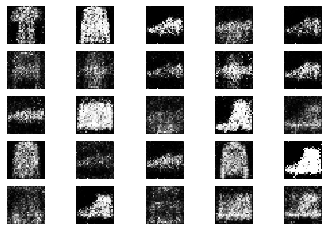

2201 [D loss: 0.684478, acc.: 59.38%] [G loss: 0.930802]
2202 [D loss: 0.674656, acc.: 56.25%] [G loss: 1.025580]
2203 [D loss: 0.649505, acc.: 59.38%] [G loss: 0.909333]
2204 [D loss: 0.606434, acc.: 70.31%] [G loss: 0.942912]
2205 [D loss: 0.634203, acc.: 60.94%] [G loss: 0.977763]
2206 [D loss: 0.628700, acc.: 68.75%] [G loss: 0.877739]
2207 [D loss: 0.702584, acc.: 48.44%] [G loss: 0.872035]
2208 [D loss: 0.643401, acc.: 59.38%] [G loss: 0.853248]
2209 [D loss: 0.602820, acc.: 73.44%] [G loss: 0.926463]
2210 [D loss: 0.609384, acc.: 65.62%] [G loss: 0.917889]
2211 [D loss: 0.534878, acc.: 73.44%] [G loss: 0.995095]
2212 [D loss: 0.631100, acc.: 60.94%] [G loss: 1.026627]
2213 [D loss: 0.645689, acc.: 60.94%] [G loss: 0.938464]
2214 [D loss: 0.657909, acc.: 59.38%] [G loss: 0.919340]
2215 [D loss: 0.639224, acc.: 65.62%] [G loss: 0.925429]
2216 [D loss: 0.636408, acc.: 64.06%] [G loss: 0.872806]
2217 [D loss: 0.582129, acc.: 70.31%] [G loss: 0.884631]
2218 [D loss: 0.539273, acc.: 7

2346 [D loss: 0.664996, acc.: 56.25%] [G loss: 0.944898]
2347 [D loss: 0.612818, acc.: 65.62%] [G loss: 0.941540]
2348 [D loss: 0.590037, acc.: 70.31%] [G loss: 0.952240]
2349 [D loss: 0.644364, acc.: 53.12%] [G loss: 0.896960]
2350 [D loss: 0.710422, acc.: 48.44%] [G loss: 0.817508]
2351 [D loss: 0.642535, acc.: 60.94%] [G loss: 0.894630]
2352 [D loss: 0.660158, acc.: 60.94%] [G loss: 0.847638]
2353 [D loss: 0.604727, acc.: 68.75%] [G loss: 0.864114]
2354 [D loss: 0.617233, acc.: 60.94%] [G loss: 0.869215]
2355 [D loss: 0.594365, acc.: 70.31%] [G loss: 0.878053]
2356 [D loss: 0.599404, acc.: 64.06%] [G loss: 0.859653]
2357 [D loss: 0.614899, acc.: 71.88%] [G loss: 0.928141]
2358 [D loss: 0.617861, acc.: 65.62%] [G loss: 0.890469]
2359 [D loss: 0.635686, acc.: 62.50%] [G loss: 0.918477]
2360 [D loss: 0.679866, acc.: 56.25%] [G loss: 1.025976]
2361 [D loss: 0.630272, acc.: 62.50%] [G loss: 0.906253]
2362 [D loss: 0.625754, acc.: 62.50%] [G loss: 1.043309]
2363 [D loss: 0.613297, acc.: 6

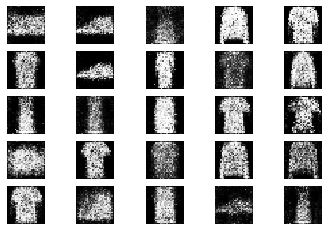

2401 [D loss: 0.673237, acc.: 46.88%] [G loss: 0.980362]
2402 [D loss: 0.626493, acc.: 70.31%] [G loss: 1.001007]
2403 [D loss: 0.521442, acc.: 81.25%] [G loss: 1.010240]
2404 [D loss: 0.656124, acc.: 60.94%] [G loss: 0.866430]
2405 [D loss: 0.619207, acc.: 71.88%] [G loss: 0.873165]
2406 [D loss: 0.645096, acc.: 60.94%] [G loss: 0.897810]
2407 [D loss: 0.567798, acc.: 70.31%] [G loss: 0.899309]
2408 [D loss: 0.566756, acc.: 70.31%] [G loss: 0.990301]
2409 [D loss: 0.623210, acc.: 68.75%] [G loss: 0.891475]
2410 [D loss: 0.638445, acc.: 60.94%] [G loss: 0.974203]
2411 [D loss: 0.599853, acc.: 68.75%] [G loss: 0.942440]
2412 [D loss: 0.552586, acc.: 79.69%] [G loss: 1.056509]
2413 [D loss: 0.632386, acc.: 64.06%] [G loss: 0.984158]
2414 [D loss: 0.618492, acc.: 59.38%] [G loss: 1.071817]
2415 [D loss: 0.648613, acc.: 62.50%] [G loss: 0.894693]
2416 [D loss: 0.595876, acc.: 70.31%] [G loss: 0.950728]
2417 [D loss: 0.622767, acc.: 59.38%] [G loss: 0.906083]
2418 [D loss: 0.581860, acc.: 7

2545 [D loss: 0.619795, acc.: 65.62%] [G loss: 0.876250]
2546 [D loss: 0.629085, acc.: 65.62%] [G loss: 0.948530]
2547 [D loss: 0.585174, acc.: 75.00%] [G loss: 0.899915]
2548 [D loss: 0.644005, acc.: 59.38%] [G loss: 0.948066]
2549 [D loss: 0.623803, acc.: 60.94%] [G loss: 0.924944]
2550 [D loss: 0.715131, acc.: 56.25%] [G loss: 0.896099]
2551 [D loss: 0.692332, acc.: 60.94%] [G loss: 0.908422]
2552 [D loss: 0.658291, acc.: 54.69%] [G loss: 1.031497]
2553 [D loss: 0.644406, acc.: 56.25%] [G loss: 1.020641]
2554 [D loss: 0.649869, acc.: 60.94%] [G loss: 0.932028]
2555 [D loss: 0.636313, acc.: 64.06%] [G loss: 0.899963]
2556 [D loss: 0.627487, acc.: 70.31%] [G loss: 0.970944]
2557 [D loss: 0.632661, acc.: 59.38%] [G loss: 0.943445]
2558 [D loss: 0.639806, acc.: 54.69%] [G loss: 1.004083]
2559 [D loss: 0.633718, acc.: 59.38%] [G loss: 0.934061]
2560 [D loss: 0.607585, acc.: 71.88%] [G loss: 0.945344]
2561 [D loss: 0.637206, acc.: 57.81%] [G loss: 1.024530]
2562 [D loss: 0.622198, acc.: 6

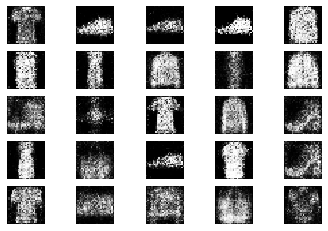

2601 [D loss: 0.646036, acc.: 56.25%] [G loss: 0.869351]
2602 [D loss: 0.591324, acc.: 65.62%] [G loss: 0.841377]
2603 [D loss: 0.652429, acc.: 54.69%] [G loss: 0.912859]
2604 [D loss: 0.609640, acc.: 65.62%] [G loss: 0.901315]
2605 [D loss: 0.623757, acc.: 60.94%] [G loss: 0.999446]
2606 [D loss: 0.672469, acc.: 60.94%] [G loss: 1.020173]
2607 [D loss: 0.635996, acc.: 64.06%] [G loss: 0.831722]
2608 [D loss: 0.615555, acc.: 67.19%] [G loss: 0.889662]
2609 [D loss: 0.685791, acc.: 57.81%] [G loss: 0.985709]
2610 [D loss: 0.619421, acc.: 64.06%] [G loss: 0.949395]
2611 [D loss: 0.630842, acc.: 57.81%] [G loss: 1.019894]
2612 [D loss: 0.628659, acc.: 67.19%] [G loss: 1.037569]
2613 [D loss: 0.614189, acc.: 67.19%] [G loss: 0.957304]
2614 [D loss: 0.637187, acc.: 62.50%] [G loss: 0.879134]
2615 [D loss: 0.621631, acc.: 64.06%] [G loss: 1.000940]
2616 [D loss: 0.674114, acc.: 57.81%] [G loss: 0.904182]
2617 [D loss: 0.562801, acc.: 78.12%] [G loss: 0.891874]
2618 [D loss: 0.630183, acc.: 6

2745 [D loss: 0.620190, acc.: 57.81%] [G loss: 0.926925]
2746 [D loss: 0.612765, acc.: 64.06%] [G loss: 0.972815]
2747 [D loss: 0.709276, acc.: 51.56%] [G loss: 0.880463]
2748 [D loss: 0.638165, acc.: 60.94%] [G loss: 0.934285]
2749 [D loss: 0.652215, acc.: 53.12%] [G loss: 0.915623]
2750 [D loss: 0.638238, acc.: 56.25%] [G loss: 0.918163]
2751 [D loss: 0.668755, acc.: 53.12%] [G loss: 0.840723]
2752 [D loss: 0.635440, acc.: 59.38%] [G loss: 0.913216]
2753 [D loss: 0.663419, acc.: 57.81%] [G loss: 0.946401]
2754 [D loss: 0.615617, acc.: 67.19%] [G loss: 0.906750]
2755 [D loss: 0.651214, acc.: 54.69%] [G loss: 0.986018]
2756 [D loss: 0.627356, acc.: 65.62%] [G loss: 0.966371]
2757 [D loss: 0.610779, acc.: 67.19%] [G loss: 0.977405]
2758 [D loss: 0.596404, acc.: 64.06%] [G loss: 0.857927]
2759 [D loss: 0.636208, acc.: 53.12%] [G loss: 0.961502]
2760 [D loss: 0.672220, acc.: 56.25%] [G loss: 0.886179]
2761 [D loss: 0.618044, acc.: 67.19%] [G loss: 0.935611]
2762 [D loss: 0.696485, acc.: 5

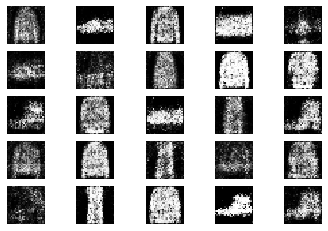

2801 [D loss: 0.622078, acc.: 70.31%] [G loss: 0.951241]
2802 [D loss: 0.637333, acc.: 64.06%] [G loss: 0.913737]
2803 [D loss: 0.625573, acc.: 67.19%] [G loss: 0.950744]
2804 [D loss: 0.663933, acc.: 54.69%] [G loss: 0.838089]
2805 [D loss: 0.625226, acc.: 64.06%] [G loss: 0.920754]
2806 [D loss: 0.563599, acc.: 75.00%] [G loss: 0.973626]
2807 [D loss: 0.556122, acc.: 68.75%] [G loss: 0.903389]
2808 [D loss: 0.635638, acc.: 64.06%] [G loss: 0.850604]
2809 [D loss: 0.620280, acc.: 62.50%] [G loss: 0.853098]
2810 [D loss: 0.757746, acc.: 46.88%] [G loss: 0.950116]
2811 [D loss: 0.667281, acc.: 60.94%] [G loss: 0.934058]
2812 [D loss: 0.727786, acc.: 56.25%] [G loss: 0.941340]
2813 [D loss: 0.640316, acc.: 60.94%] [G loss: 0.882869]
2814 [D loss: 0.647123, acc.: 59.38%] [G loss: 0.880169]
2815 [D loss: 0.628945, acc.: 67.19%] [G loss: 0.913713]
2816 [D loss: 0.612282, acc.: 68.75%] [G loss: 0.968996]
2817 [D loss: 0.602170, acc.: 67.19%] [G loss: 0.884868]
2818 [D loss: 0.665851, acc.: 6

2945 [D loss: 0.672089, acc.: 56.25%] [G loss: 0.963491]
2946 [D loss: 0.710734, acc.: 54.69%] [G loss: 0.911770]
2947 [D loss: 0.699576, acc.: 57.81%] [G loss: 0.878688]
2948 [D loss: 0.661590, acc.: 53.12%] [G loss: 0.932412]
2949 [D loss: 0.665669, acc.: 57.81%] [G loss: 0.866362]
2950 [D loss: 0.649786, acc.: 62.50%] [G loss: 0.860855]
2951 [D loss: 0.619562, acc.: 62.50%] [G loss: 0.891762]
2952 [D loss: 0.661775, acc.: 64.06%] [G loss: 0.919899]
2953 [D loss: 0.601614, acc.: 70.31%] [G loss: 0.933794]
2954 [D loss: 0.669365, acc.: 54.69%] [G loss: 0.890216]
2955 [D loss: 0.649887, acc.: 54.69%] [G loss: 0.887673]
2956 [D loss: 0.601746, acc.: 60.94%] [G loss: 0.863103]
2957 [D loss: 0.564773, acc.: 76.56%] [G loss: 0.963938]
2958 [D loss: 0.656166, acc.: 64.06%] [G loss: 0.922053]
2959 [D loss: 0.643114, acc.: 51.56%] [G loss: 0.949955]
2960 [D loss: 0.665434, acc.: 62.50%] [G loss: 1.000365]
2961 [D loss: 0.651131, acc.: 64.06%] [G loss: 1.088873]
2962 [D loss: 0.607334, acc.: 6

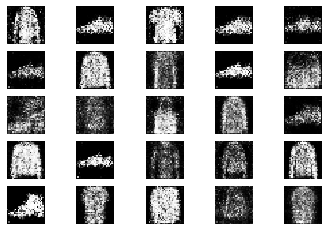

3001 [D loss: 0.630549, acc.: 56.25%] [G loss: 0.853849]
3002 [D loss: 0.679323, acc.: 56.25%] [G loss: 0.997723]
3003 [D loss: 0.648892, acc.: 65.62%] [G loss: 0.917081]
3004 [D loss: 0.705491, acc.: 50.00%] [G loss: 1.017992]
3005 [D loss: 0.645382, acc.: 64.06%] [G loss: 0.869337]
3006 [D loss: 0.624054, acc.: 64.06%] [G loss: 0.854734]
3007 [D loss: 0.604787, acc.: 75.00%] [G loss: 0.873125]
3008 [D loss: 0.584051, acc.: 67.19%] [G loss: 0.921344]
3009 [D loss: 0.602721, acc.: 65.62%] [G loss: 0.968459]
3010 [D loss: 0.640920, acc.: 64.06%] [G loss: 0.892876]
3011 [D loss: 0.628744, acc.: 60.94%] [G loss: 0.952439]
3012 [D loss: 0.628271, acc.: 60.94%] [G loss: 0.901193]
3013 [D loss: 0.686440, acc.: 53.12%] [G loss: 0.911752]
3014 [D loss: 0.630792, acc.: 70.31%] [G loss: 0.904204]
3015 [D loss: 0.630227, acc.: 64.06%] [G loss: 0.895820]
3016 [D loss: 0.616987, acc.: 65.62%] [G loss: 0.981732]
3017 [D loss: 0.592269, acc.: 70.31%] [G loss: 0.958522]
3018 [D loss: 0.658771, acc.: 6

3145 [D loss: 0.642973, acc.: 64.06%] [G loss: 0.965804]
3146 [D loss: 0.590971, acc.: 62.50%] [G loss: 0.874678]
3147 [D loss: 0.662026, acc.: 64.06%] [G loss: 0.870633]
3148 [D loss: 0.670443, acc.: 54.69%] [G loss: 0.926871]
3149 [D loss: 0.555132, acc.: 75.00%] [G loss: 1.010182]
3150 [D loss: 0.601997, acc.: 67.19%] [G loss: 0.912434]
3151 [D loss: 0.612119, acc.: 68.75%] [G loss: 1.003954]
3152 [D loss: 0.580899, acc.: 67.19%] [G loss: 0.896233]
3153 [D loss: 0.656206, acc.: 59.38%] [G loss: 0.898643]
3154 [D loss: 0.602401, acc.: 70.31%] [G loss: 0.998509]
3155 [D loss: 0.575913, acc.: 78.12%] [G loss: 1.028055]
3156 [D loss: 0.569005, acc.: 73.44%] [G loss: 0.958426]
3157 [D loss: 0.689328, acc.: 59.38%] [G loss: 0.989506]
3158 [D loss: 0.658570, acc.: 67.19%] [G loss: 0.866008]
3159 [D loss: 0.575207, acc.: 70.31%] [G loss: 0.877251]
3160 [D loss: 0.547906, acc.: 79.69%] [G loss: 0.956724]
3161 [D loss: 0.577242, acc.: 65.62%] [G loss: 1.123888]
3162 [D loss: 0.648530, acc.: 5

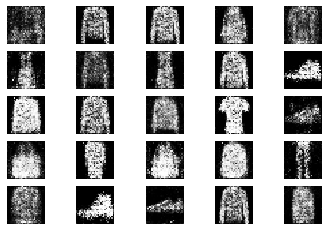

3201 [D loss: 0.600582, acc.: 67.19%] [G loss: 0.969753]
3202 [D loss: 0.660154, acc.: 53.12%] [G loss: 0.934444]
3203 [D loss: 0.649570, acc.: 56.25%] [G loss: 0.980429]
3204 [D loss: 0.684395, acc.: 57.81%] [G loss: 0.945720]
3205 [D loss: 0.623108, acc.: 64.06%] [G loss: 0.876062]
3206 [D loss: 0.576661, acc.: 71.88%] [G loss: 0.906270]
3207 [D loss: 0.603012, acc.: 68.75%] [G loss: 0.829456]
3208 [D loss: 0.690729, acc.: 60.94%] [G loss: 0.885455]
3209 [D loss: 0.646454, acc.: 64.06%] [G loss: 0.950436]
3210 [D loss: 0.572622, acc.: 64.06%] [G loss: 0.900397]
3211 [D loss: 0.666051, acc.: 62.50%] [G loss: 0.842593]
3212 [D loss: 0.633119, acc.: 64.06%] [G loss: 0.868730]
3213 [D loss: 0.666092, acc.: 56.25%] [G loss: 0.862413]
3214 [D loss: 0.693659, acc.: 48.44%] [G loss: 0.876564]
3215 [D loss: 0.633446, acc.: 57.81%] [G loss: 0.904331]
3216 [D loss: 0.602805, acc.: 68.75%] [G loss: 0.908911]
3217 [D loss: 0.689577, acc.: 57.81%] [G loss: 0.923250]
3218 [D loss: 0.574615, acc.: 6

3346 [D loss: 0.655886, acc.: 56.25%] [G loss: 0.882619]
3347 [D loss: 0.608837, acc.: 65.62%] [G loss: 0.854027]
3348 [D loss: 0.593957, acc.: 64.06%] [G loss: 0.887804]
3349 [D loss: 0.626099, acc.: 64.06%] [G loss: 0.858633]
3350 [D loss: 0.673025, acc.: 57.81%] [G loss: 0.967161]
3351 [D loss: 0.632744, acc.: 68.75%] [G loss: 0.987853]
3352 [D loss: 0.688372, acc.: 54.69%] [G loss: 0.950310]
3353 [D loss: 0.625234, acc.: 60.94%] [G loss: 0.944070]
3354 [D loss: 0.672095, acc.: 56.25%] [G loss: 1.037367]
3355 [D loss: 0.686544, acc.: 60.94%] [G loss: 1.066791]
3356 [D loss: 0.597866, acc.: 67.19%] [G loss: 0.959859]
3357 [D loss: 0.601947, acc.: 75.00%] [G loss: 0.924573]
3358 [D loss: 0.707398, acc.: 54.69%] [G loss: 0.918157]
3359 [D loss: 0.616322, acc.: 60.94%] [G loss: 0.974846]
3360 [D loss: 0.608261, acc.: 57.81%] [G loss: 0.988305]
3361 [D loss: 0.588316, acc.: 71.88%] [G loss: 1.005477]
3362 [D loss: 0.639648, acc.: 59.38%] [G loss: 1.044092]
3363 [D loss: 0.597673, acc.: 7

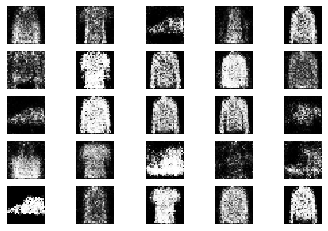

3401 [D loss: 0.651300, acc.: 65.62%] [G loss: 0.949906]
3402 [D loss: 0.583235, acc.: 71.88%] [G loss: 0.930702]
3403 [D loss: 0.716102, acc.: 50.00%] [G loss: 0.956711]
3404 [D loss: 0.645883, acc.: 62.50%] [G loss: 1.075580]
3405 [D loss: 0.594819, acc.: 67.19%] [G loss: 1.057409]
3406 [D loss: 0.603718, acc.: 68.75%] [G loss: 0.884476]
3407 [D loss: 0.634841, acc.: 59.38%] [G loss: 0.934358]
3408 [D loss: 0.680666, acc.: 50.00%] [G loss: 0.981924]
3409 [D loss: 0.630430, acc.: 62.50%] [G loss: 0.906159]
3410 [D loss: 0.715857, acc.: 53.12%] [G loss: 0.976119]
3411 [D loss: 0.655843, acc.: 64.06%] [G loss: 0.936411]
3412 [D loss: 0.589468, acc.: 70.31%] [G loss: 0.924003]
3413 [D loss: 0.621749, acc.: 67.19%] [G loss: 0.802491]
3414 [D loss: 0.601928, acc.: 67.19%] [G loss: 0.905994]
3415 [D loss: 0.680979, acc.: 51.56%] [G loss: 0.886202]
3416 [D loss: 0.690862, acc.: 62.50%] [G loss: 0.898141]
3417 [D loss: 0.609246, acc.: 68.75%] [G loss: 1.027265]
3418 [D loss: 0.617569, acc.: 6

3545 [D loss: 0.673923, acc.: 48.44%] [G loss: 1.036954]
3546 [D loss: 0.643381, acc.: 59.38%] [G loss: 1.009418]
3547 [D loss: 0.729929, acc.: 45.31%] [G loss: 0.997824]
3548 [D loss: 0.698091, acc.: 56.25%] [G loss: 1.077838]
3549 [D loss: 0.671176, acc.: 60.94%] [G loss: 1.056385]
3550 [D loss: 0.648712, acc.: 65.62%] [G loss: 0.951414]
3551 [D loss: 0.753891, acc.: 48.44%] [G loss: 0.809730]
3552 [D loss: 0.620682, acc.: 70.31%] [G loss: 0.836803]
3553 [D loss: 0.645785, acc.: 62.50%] [G loss: 0.891181]
3554 [D loss: 0.656975, acc.: 60.94%] [G loss: 0.893424]
3555 [D loss: 0.686546, acc.: 51.56%] [G loss: 0.923707]
3556 [D loss: 0.623131, acc.: 70.31%] [G loss: 0.912980]
3557 [D loss: 0.644727, acc.: 64.06%] [G loss: 0.933064]
3558 [D loss: 0.691285, acc.: 62.50%] [G loss: 1.049587]
3559 [D loss: 0.664178, acc.: 64.06%] [G loss: 0.911778]
3560 [D loss: 0.668619, acc.: 65.62%] [G loss: 0.969753]
3561 [D loss: 0.656260, acc.: 59.38%] [G loss: 0.978520]
3562 [D loss: 0.583291, acc.: 7

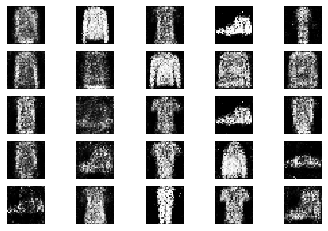

3601 [D loss: 0.669096, acc.: 59.38%] [G loss: 0.875203]
3602 [D loss: 0.651313, acc.: 68.75%] [G loss: 0.867355]
3603 [D loss: 0.724068, acc.: 53.12%] [G loss: 0.905567]
3604 [D loss: 0.594128, acc.: 71.88%] [G loss: 0.932662]
3605 [D loss: 0.637678, acc.: 68.75%] [G loss: 0.901867]
3606 [D loss: 0.663531, acc.: 57.81%] [G loss: 0.871274]
3607 [D loss: 0.689186, acc.: 54.69%] [G loss: 0.948569]
3608 [D loss: 0.657147, acc.: 68.75%] [G loss: 0.913173]
3609 [D loss: 0.604797, acc.: 62.50%] [G loss: 0.877734]
3610 [D loss: 0.646139, acc.: 60.94%] [G loss: 0.955653]
3611 [D loss: 0.658993, acc.: 68.75%] [G loss: 0.981108]
3612 [D loss: 0.652048, acc.: 62.50%] [G loss: 0.945119]
3613 [D loss: 0.586521, acc.: 71.88%] [G loss: 0.826548]
3614 [D loss: 0.597617, acc.: 65.62%] [G loss: 0.839633]
3615 [D loss: 0.686512, acc.: 59.38%] [G loss: 0.948700]
3616 [D loss: 0.623834, acc.: 60.94%] [G loss: 0.989898]
3617 [D loss: 0.683733, acc.: 46.88%] [G loss: 0.986371]
3618 [D loss: 0.638585, acc.: 5

3745 [D loss: 0.677319, acc.: 56.25%] [G loss: 0.847581]
3746 [D loss: 0.633720, acc.: 70.31%] [G loss: 0.859382]
3747 [D loss: 0.646568, acc.: 65.62%] [G loss: 0.866410]
3748 [D loss: 0.744319, acc.: 42.19%] [G loss: 0.958884]
3749 [D loss: 0.659764, acc.: 60.94%] [G loss: 0.917168]
3750 [D loss: 0.727244, acc.: 46.88%] [G loss: 0.957843]
3751 [D loss: 0.718580, acc.: 45.31%] [G loss: 0.872795]
3752 [D loss: 0.645714, acc.: 60.94%] [G loss: 0.930927]
3753 [D loss: 0.641477, acc.: 60.94%] [G loss: 0.962022]
3754 [D loss: 0.702784, acc.: 57.81%] [G loss: 0.919082]
3755 [D loss: 0.601029, acc.: 68.75%] [G loss: 0.946487]
3756 [D loss: 0.619464, acc.: 68.75%] [G loss: 0.928268]
3757 [D loss: 0.649858, acc.: 65.62%] [G loss: 0.942598]
3758 [D loss: 0.649594, acc.: 57.81%] [G loss: 0.911856]
3759 [D loss: 0.608808, acc.: 62.50%] [G loss: 0.896124]
3760 [D loss: 0.671913, acc.: 59.38%] [G loss: 0.915449]
3761 [D loss: 0.612306, acc.: 71.88%] [G loss: 0.933109]
3762 [D loss: 0.605689, acc.: 6

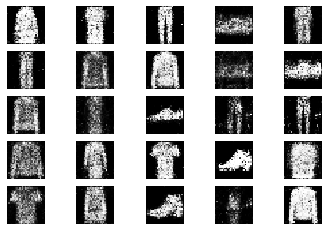

3801 [D loss: 0.626492, acc.: 64.06%] [G loss: 1.000219]
3802 [D loss: 0.589711, acc.: 75.00%] [G loss: 0.909859]
3803 [D loss: 0.632170, acc.: 65.62%] [G loss: 0.942888]
3804 [D loss: 0.609971, acc.: 70.31%] [G loss: 0.885837]
3805 [D loss: 0.707378, acc.: 54.69%] [G loss: 0.877416]
3806 [D loss: 0.648406, acc.: 68.75%] [G loss: 0.831643]
3807 [D loss: 0.625484, acc.: 62.50%] [G loss: 0.881864]
3808 [D loss: 0.651601, acc.: 56.25%] [G loss: 0.894892]
3809 [D loss: 0.668409, acc.: 56.25%] [G loss: 0.894255]
3810 [D loss: 0.624620, acc.: 59.38%] [G loss: 0.908831]
3811 [D loss: 0.673921, acc.: 56.25%] [G loss: 1.036336]
3812 [D loss: 0.699346, acc.: 57.81%] [G loss: 0.918450]
3813 [D loss: 0.649906, acc.: 64.06%] [G loss: 0.864236]
3814 [D loss: 0.674223, acc.: 59.38%] [G loss: 0.954973]
3815 [D loss: 0.678285, acc.: 51.56%] [G loss: 0.877622]
3816 [D loss: 0.685635, acc.: 53.12%] [G loss: 0.935030]
3817 [D loss: 0.694460, acc.: 56.25%] [G loss: 0.975779]
3818 [D loss: 0.649453, acc.: 5

3945 [D loss: 0.599983, acc.: 68.75%] [G loss: 0.839116]
3946 [D loss: 0.646676, acc.: 57.81%] [G loss: 0.860106]
3947 [D loss: 0.658715, acc.: 56.25%] [G loss: 0.894141]
3948 [D loss: 0.610506, acc.: 70.31%] [G loss: 0.917612]
3949 [D loss: 0.644259, acc.: 64.06%] [G loss: 0.894943]
3950 [D loss: 0.622567, acc.: 59.38%] [G loss: 0.851911]
3951 [D loss: 0.614209, acc.: 60.94%] [G loss: 0.886843]
3952 [D loss: 0.735554, acc.: 51.56%] [G loss: 0.868091]
3953 [D loss: 0.730041, acc.: 51.56%] [G loss: 0.875005]
3954 [D loss: 0.666007, acc.: 57.81%] [G loss: 0.910893]
3955 [D loss: 0.631551, acc.: 62.50%] [G loss: 0.909150]
3956 [D loss: 0.695798, acc.: 51.56%] [G loss: 0.912467]
3957 [D loss: 0.627240, acc.: 60.94%] [G loss: 0.910360]
3958 [D loss: 0.651710, acc.: 60.94%] [G loss: 1.007936]
3959 [D loss: 0.689183, acc.: 53.12%] [G loss: 0.908684]
3960 [D loss: 0.639854, acc.: 62.50%] [G loss: 0.934384]
3961 [D loss: 0.713474, acc.: 64.06%] [G loss: 0.958631]
3962 [D loss: 0.764049, acc.: 4

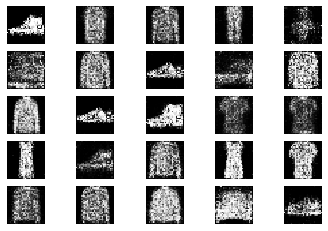

4001 [D loss: 0.693283, acc.: 62.50%] [G loss: 0.856981]
4002 [D loss: 0.668118, acc.: 62.50%] [G loss: 0.780369]
4003 [D loss: 0.647195, acc.: 64.06%] [G loss: 0.792399]
4004 [D loss: 0.613220, acc.: 64.06%] [G loss: 0.932350]
4005 [D loss: 0.643888, acc.: 60.94%] [G loss: 0.930900]
4006 [D loss: 0.700120, acc.: 45.31%] [G loss: 0.889039]
4007 [D loss: 0.634877, acc.: 57.81%] [G loss: 1.029053]
4008 [D loss: 0.653834, acc.: 54.69%] [G loss: 0.994146]
4009 [D loss: 0.682914, acc.: 53.12%] [G loss: 0.878904]
4010 [D loss: 0.618106, acc.: 70.31%] [G loss: 0.896635]
4011 [D loss: 0.605732, acc.: 67.19%] [G loss: 0.858964]
4012 [D loss: 0.551523, acc.: 75.00%] [G loss: 0.966399]
4013 [D loss: 0.729993, acc.: 60.94%] [G loss: 0.903795]
4014 [D loss: 0.702728, acc.: 59.38%] [G loss: 0.901843]
4015 [D loss: 0.644327, acc.: 60.94%] [G loss: 0.866078]
4016 [D loss: 0.655815, acc.: 60.94%] [G loss: 0.871861]
4017 [D loss: 0.667400, acc.: 59.38%] [G loss: 0.954923]
4018 [D loss: 0.700759, acc.: 6

4146 [D loss: 0.563213, acc.: 68.75%] [G loss: 0.977941]
4147 [D loss: 0.637385, acc.: 65.62%] [G loss: 0.989493]
4148 [D loss: 0.670760, acc.: 56.25%] [G loss: 0.949011]
4149 [D loss: 0.668970, acc.: 62.50%] [G loss: 0.993488]
4150 [D loss: 0.672256, acc.: 57.81%] [G loss: 0.957889]
4151 [D loss: 0.582985, acc.: 68.75%] [G loss: 0.840510]
4152 [D loss: 0.625242, acc.: 67.19%] [G loss: 0.952482]
4153 [D loss: 0.656566, acc.: 62.50%] [G loss: 0.972356]
4154 [D loss: 0.619676, acc.: 65.62%] [G loss: 0.946639]
4155 [D loss: 0.647014, acc.: 54.69%] [G loss: 0.930040]
4156 [D loss: 0.637486, acc.: 62.50%] [G loss: 0.933492]
4157 [D loss: 0.638724, acc.: 65.62%] [G loss: 0.930442]
4158 [D loss: 0.575242, acc.: 75.00%] [G loss: 0.871096]
4159 [D loss: 0.603070, acc.: 67.19%] [G loss: 0.929927]
4160 [D loss: 0.652549, acc.: 56.25%] [G loss: 0.890816]
4161 [D loss: 0.735845, acc.: 45.31%] [G loss: 0.981061]
4162 [D loss: 0.669270, acc.: 54.69%] [G loss: 0.931266]
4163 [D loss: 0.620018, acc.: 6

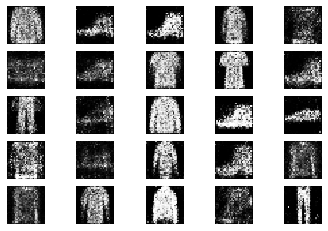

4201 [D loss: 0.674070, acc.: 54.69%] [G loss: 0.865719]
4202 [D loss: 0.687684, acc.: 50.00%] [G loss: 0.898201]
4203 [D loss: 0.644629, acc.: 53.12%] [G loss: 0.842451]
4204 [D loss: 0.591351, acc.: 70.31%] [G loss: 0.845095]
4205 [D loss: 0.626577, acc.: 64.06%] [G loss: 0.906677]
4206 [D loss: 0.688128, acc.: 51.56%] [G loss: 0.931083]
4207 [D loss: 0.631324, acc.: 65.62%] [G loss: 0.931929]
4208 [D loss: 0.657940, acc.: 59.38%] [G loss: 0.885775]
4209 [D loss: 0.624882, acc.: 70.31%] [G loss: 0.826302]
4210 [D loss: 0.721115, acc.: 51.56%] [G loss: 0.904652]
4211 [D loss: 0.779039, acc.: 51.56%] [G loss: 0.812330]
4212 [D loss: 0.669904, acc.: 60.94%] [G loss: 0.855110]
4213 [D loss: 0.611275, acc.: 75.00%] [G loss: 0.914869]
4214 [D loss: 0.613972, acc.: 65.62%] [G loss: 0.838962]
4215 [D loss: 0.641314, acc.: 73.44%] [G loss: 0.965282]
4216 [D loss: 0.657519, acc.: 64.06%] [G loss: 0.852320]
4217 [D loss: 0.653096, acc.: 64.06%] [G loss: 0.957701]
4218 [D loss: 0.727745, acc.: 5

4345 [D loss: 0.652729, acc.: 62.50%] [G loss: 0.803023]
4346 [D loss: 0.670971, acc.: 59.38%] [G loss: 0.871440]
4347 [D loss: 0.721479, acc.: 43.75%] [G loss: 0.827122]
4348 [D loss: 0.668394, acc.: 59.38%] [G loss: 0.895170]
4349 [D loss: 0.626806, acc.: 65.62%] [G loss: 0.933551]
4350 [D loss: 0.673672, acc.: 56.25%] [G loss: 0.959660]
4351 [D loss: 0.627403, acc.: 73.44%] [G loss: 0.855411]
4352 [D loss: 0.676595, acc.: 62.50%] [G loss: 0.851290]
4353 [D loss: 0.633269, acc.: 68.75%] [G loss: 0.936211]
4354 [D loss: 0.638460, acc.: 64.06%] [G loss: 0.945366]
4355 [D loss: 0.700935, acc.: 59.38%] [G loss: 0.937757]
4356 [D loss: 0.630514, acc.: 65.62%] [G loss: 0.925844]
4357 [D loss: 0.613967, acc.: 70.31%] [G loss: 0.843259]
4358 [D loss: 0.687546, acc.: 62.50%] [G loss: 0.875906]
4359 [D loss: 0.644929, acc.: 62.50%] [G loss: 0.954160]
4360 [D loss: 0.665710, acc.: 64.06%] [G loss: 0.912357]
4361 [D loss: 0.688063, acc.: 56.25%] [G loss: 0.974648]
4362 [D loss: 0.623554, acc.: 6

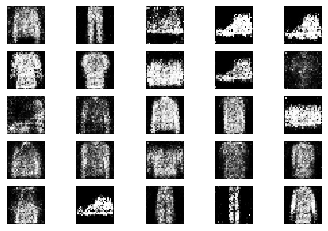

4401 [D loss: 0.694300, acc.: 48.44%] [G loss: 0.915790]
4402 [D loss: 0.651082, acc.: 59.38%] [G loss: 0.872244]
4403 [D loss: 0.708601, acc.: 57.81%] [G loss: 0.931421]
4404 [D loss: 0.646757, acc.: 62.50%] [G loss: 0.944473]
4405 [D loss: 0.614314, acc.: 62.50%] [G loss: 1.009527]
4406 [D loss: 0.660309, acc.: 60.94%] [G loss: 0.833531]
4407 [D loss: 0.708108, acc.: 60.94%] [G loss: 0.854876]
4408 [D loss: 0.710874, acc.: 51.56%] [G loss: 0.952117]
4409 [D loss: 0.648859, acc.: 64.06%] [G loss: 0.812624]
4410 [D loss: 0.650930, acc.: 60.94%] [G loss: 0.803600]
4411 [D loss: 0.720940, acc.: 45.31%] [G loss: 0.953554]
4412 [D loss: 0.680589, acc.: 56.25%] [G loss: 0.989973]
4413 [D loss: 0.651165, acc.: 62.50%] [G loss: 0.825747]
4414 [D loss: 0.743588, acc.: 50.00%] [G loss: 0.961697]
4415 [D loss: 0.632645, acc.: 65.62%] [G loss: 0.940045]
4416 [D loss: 0.633450, acc.: 67.19%] [G loss: 0.966412]
4417 [D loss: 0.660624, acc.: 56.25%] [G loss: 0.846516]
4418 [D loss: 0.720371, acc.: 4

In [ ]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, sample_interval=200)

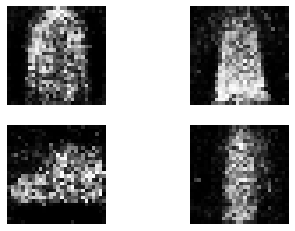

In [8]:
#2 examples of generated images inside of a jupyter notebook. 
#MJ - Had some issues with plotting a 2x1 array of images, so including 2 extra images for free!

r, c = 2, 2
noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
gen_imgs = gan.generator.predict(noise)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()

In [ ]:
# Above:  Results after 3,000 epochs
# Below:  Results after 30,000 epochs

In [ ]:

r, c = 2, 2
noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
gen_imgs = gan.generator.predict(noise)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()